In [1]:
from math import *
import cv2
import os
import numpy as np
import glob
import time
import itertools

import matplotlib.image as mpimg
import matplotlib.pyplot as plt

from sklearn.externals import joblib
from scipy.ndimage.measurements import label

# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML

from training import *
from detection import *

np.random.seed(0xdeadbeef)


In [2]:
from sklearn.externals import joblib
data = joblib.load('Models//clf_9764.pkl')
# data = joblib.load('models/clf_9869.pkl')
# svc = data['model']
clf = data['model']
config = data['config']

color_space = config['color_space']
spatial_size = config['spatial_size']
hist_bins = config['hist_bins']
orient = config['orient']
pix_per_cell = config['pix_per_cell']
cell_per_block = config['cell_per_block']
hog_channel = config['hog_channel']
spatial_feat = config['spatial_feat']
hist_feat = config['hist_feat']
hog_feat = config['hog_feat']
print(config)

{'spatial_size': (16, 16), 'hog_channel': 0, 'hist_feat': True, 'hog_feat': True, 'color_space': 'YCrCb', 'orient': 9, 'hist_bins': 16, 'spatial_feat': True, 'cell_per_block': 2, 'pix_per_cell': 8}


In [3]:
pyramid = [((64, 64),  [400, 500]),
           ((96, 96),  [400, 500]),
           ((128, 128),[450, 578]),
           ((192, 192),[450, None]),
#             ((256, 256),[450, None])
      ]
image_size = (720, 1280)
windows = create_windows(pyramid, image_size)

In [4]:
from tracking import *

In [5]:
from filters import kalman_predict, kalman_correct
from scipy.optimize import linear_sum_assignment
import itertools
import functools
import collections

def bbox_overlap(box1, box2):
    x1, y1, x2, y2 = box1
    x3, y3, x4, y4 = box2

    area = (x4 - x3 + 1) * (y4 - y3 + 1)

    xx1 = np.maximum(x1, x3)
    yy1 = np.maximum(y1, y3)
    xx2 = np.minimum(x2, x4)
    yy2 = np.minimum(y2, y4)

    # compute the width and height of the bounding box
    w = np.maximum(0, xx2 - xx1 + 1)
    h = np.maximum(0, yy2 - yy1 + 1)

    # compute the ratio of overlap
    overlap = (w * h) / area
    return overlap

    
def centroid(box, as_int=False):
    x1, y1, x2, y2 = box
    if not as_int:
        return ((x1+x2)/2., (y1+y2)/2.)
    else:
        return (int((x1+x2)//2), ((y1+y2)//2))
    
class VehicleTracker(object):
    """
    Tracks vehicle candidates using a Kalman filter
    """
    draw_threshold = -15
    lock_threshold = -50
    def __init__(self, img_size, process_noise = 100.0, measurement_noise = 2000.0):
        """
        Parameters
        ----------
        img_size : tuple
            The shape of the video frame
            
        process_noise : float
            Process noise for kalman filter [pixels^2]
        
        measurement_noise : float
            Measurement covariance in x and y directions [pixels^2]
        """
        self.img_size = img_size
        self.H = np.array([[1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
                           [0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
                           [0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
                           [0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],])
        self.R = np.eye(4)*measurement_noise
                
        self.F = np.array([[0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.],
                           [0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.],
                           [0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.],
                           [0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.],
                           [0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.],
                           [0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.],
                           [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0.],
                           [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
                           [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
                           [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
                           [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
                           [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],])
        
        self.Q = np.diag([process_noise,process_noise,process_noise,process_noise,
                 process_noise*10, process_noise*10, process_noise*10, process_noise*10,
                 process_noise*100, process_noise*100, process_noise*100, process_noise*100])

        self.P0 = np.eye(12)*10e3  # Initial covariance of any new candidate
        self.predict = functools.partial(kalman_predict, F = self.F, Q = self.Q)
        self.correct = functools.partial(kalman_correct, H = self.H, R = self.R)
    
        self.candidates = []
    
    def create_candidate(self, meas):
        """
        Creates a new tracking candidate from a measurement (bounding box)
        
        Parameters
        ----------
        meas - tuple
            tuple of 4 numbers denoting the top-left and bottom-right corners of the box
        """
        # Position
        x = list(meas)
        # Velocity and Acceleration
        mag = 0.05
        x.extend([-mag*2 if x[0] > self.img_size[1]/2 else mag*5,
                  -mag,
                  -mag*2 if x[0] > self.img_size[1]/2 else mag*5,
                  -mag, 
                  0.00, 0.00, 0.00, 0.00])
        
        return {'x': np.array(x), 'P': np.copy(self.P0), 'age': 0}
        
    def detect(self, measurements):
        """
        Uses measurements from OpenCV detect vehicles in the video stream
        
        Parameters
        ----------
        measurements : list
            List of bounding boxes detected by the classifier (and heatmap)
        """
        measurements = non_max_suppression_fast(np.array(measurements), overlapThresh=0.01)
        meas_centroid = np.array([centroid(meas) for meas in measurements])
        if len(self.candidates) == 0:
            self.candidates = [self.create_candidate(meas) for meas in measurements]
        else:
            # Assign measurements to candidates based on overlap
            cand_measurements = collections.defaultdict(list)
            for j, (meas, cent) in enumerate(zip(measurements, meas_centroid)):
                # Overlap with each candidate
                overlap = [bbox_overlap(cand['x'][:4], meas) for cand in self.candidates]
                # Distance to each candidate
                distance = [np.linalg.norm(centroid(cand['x'][:4]) - cent) for cand in self.candidates]
                
                max_cand_idx = np.argmax(overlap)
                min_dist_idx = np.argmin(distance)
                
                if overlap[max_cand_idx] < 0.01 and distance[max_cand_idx] > 150:
                    self.candidates.append(self.create_candidate(meas))
                else:
                    # Assign measurement to candidate
                    if overlap[max_cand_idx] >= 0.01:
                        cand_measurements[max_cand_idx].append(meas)
                    else:
                        cand_measurements[min_dist_idx].append(meas)
            for i, cand in enumerate(self.candidates):
                meas_list = cand_measurements[i]
                x1, P1 = self.predict(x = cand['x'], P = cand['P'])

                for meas in meas_list:
                    x1, P1 = self.correct(z = meas, x = x1, P = P1)

                # Increment age if no measurements matched this candidate
                if cand['age'] > self.lock_threshold:
                    if not meas_list:
                        self.candidates[i]['age'] = cand['age'] + 1
                    else:
                        self.candidates[i]['age'] = cand['age'] - 1
                self.candidates[i]['x'] = x1
                self.candidates[i]['P'] = P1
            
            self.cleanup()

    def cleanup(self, max_age=5):
        """
        Deletes any candidates older than max_age
        
        Parameters
        ----------
        max_age : int
            Maximum age of candidate before which it is deleted
        """
        obox_tl = (0.05*self.img_size[1], 0.55*self.img_size[0])
        obox_br = (0.95*self.img_size[1], 0.95*self.img_size[0])
        self.candidates = [c for c in self.candidates if c['age'] <= max_age
                           if c['x'][1] >= obox_tl[1] or c['x'][0] >= obox_tl[0]]
    
    def draw_bboxes(self, image):
        font = cv2.FONT_HERSHEY_PLAIN

        for c in self.candidates:
            bbox = c['x'][:4].astype(np.int32)
            if c['age'] > self.draw_threshold:
                continue
            cv2.rectangle(image, (bbox[0], bbox[1]), (bbox[2], bbox[3]), (0,255,0), 3)

        return image

tracker = VehicleTracker((720, 1280))
meas1 = [(864, 432, 928, 496), (816, 400, 912, 496), (1152, 400, 1248, 496)]
meas2 = [(874, 432, 918, 496), (826, 400, 912, 456), (1122, 400, 1238, 496)]
tracker.detect(meas1)
tracker.detect(meas2)
print(len(tracker.candidates))

2


In [32]:
from detection import *
def process_image(image, params):
    config, clf, all_windows = params['clf_config'], params['clf'], params['windows']

    if params['cache_enabled']:
        cache = process_image.cache
        if cache['heatmaps'] is None:
            cache['heatmaps'] = collections.deque(maxlen=params['heatmap_cache_length'])
        
        if 'tracker' not in cache:
            cache['tracker'] = VehicleTracker(image.shape)
        frame_ctr = cache['frame_ctr']
        tracker = cache['tracker']
        cache['frame_ctr'] += 1

#         windows = all_windows[frame_ctr % len(all_windows)]# + extra
        windows = itertools.chain(*all_windows)
    else:
        windows = itertools.chain(*all_windows)

    measurements = multiscale_detect(image, clf, config, windows)
    #plt.imshow(measurements)
    #plt.show()
    current_heatmap = update_heatmap(measurements, image.shape)
    
    if not params['cache_enabled']:
        thresh_heatmap = current_heatmap
    else:
        cache['heatmaps'].append(current_heatmap)
        thresh_heatmap = sum(cache['heatmaps'])
    
    thresh_heatmap[thresh_heatmap < params['heatmap_threshold']] = 0
    cv2.GaussianBlur(thresh_heatmap, (31,31), 0, dst=thresh_heatmap)

    labels = label(thresh_heatmap)
   
    if not params['cache_enabled']:
        im2 = draw_labeled_bboxes(np.copy(image), labels)
    else:
        Z = []
        for car_number in range(1, labels[1]+1):
            nonzero = (labels[0] == car_number).nonzero()
            nonzeroy = np.array(nonzero[0])
            nonzerox = np.array(nonzero[1])
            Z.append((np.min(nonzerox), np.min(nonzeroy), np.max(nonzerox), np.max(nonzeroy)))
        tracker.detect(Z)
        im2 = tracker.draw_bboxes(np.copy(image))
        
    return [im2,labels[0]]

def clear_cache():
    process_image.cache = {
        'meas': None,
        'heatmaps': None,
        'frame_ctr': 0
    }
    

test_images\test1.jpg
test_images\test2.jpg
test_images\test3.jpg
test_images\test4.jpg


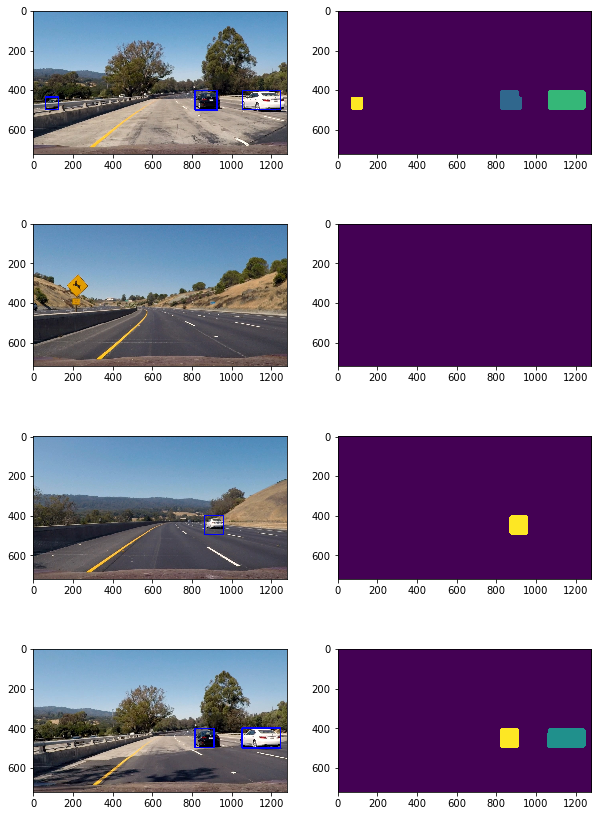

In [34]:
clear_cache()
params = {}
params['clf_config'] = config
params['clf'] = clf
params['windows'] = windows
params['cache_enabled'] = False
params['heatmap_cache_length'] = 10
params['heatmap_threshold'] = 1

#image = mpimg.imread('test_images/test3.jpg')
#im2 = process_image(image, params)
#plt.imshow(im2)
#plt.show()
out_images = glob.glob('test_images/*.jpg')
plt.figure(figsize=(10,15))
for i, fname in enumerate(out_images[:4]):
    print(fname)
    img = mpimg.imread(fname)
    im2 = process_image(img, params)
    nameofImage="out"+str(i)+".png"
    mpimg.imsave(nameofImage, im2[1])
    plt.subplot(4, 2, 2*i+1)
    plt.imshow(im2[0])
    plt.subplot(4, 2, 2*i+2)
    plt.imshow(im2[1])
    
plt.show()

In [19]:
clear_cache()
params = {}
params['clf_config'] = config
params['clf'] = clf
params['windows'] = windows
params['cache_enabled'] = True
params['heatmap_cache_length'] = 25
params['heatmap_threshold'] = 5

vid_output = 'Output/test_video_out.mp4'
clip = VideoFileClip('test_video.mp4')

In [21]:
vid_clip = clip.fl_image(lambda x: process_image(x, params)[0])
vid_clip.write_videofile(vid_output, audio=False)

[MoviePy] >>>> Building video Output/test_video_out.mp4
[MoviePy] Writing video Output/test_video_out.mp4


 97%|███████████████████████████████████████████████████████████████████████████████▉  | 38/39 [00:05<00:00,  7.57it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: Output/test_video_out.mp4 



In [42]:
clear_cache()
params = {}
params['clf_config'] = config
params['clf'] = clf
params['windows'] = windows
params['cache_enabled'] = True
params['heatmap_cache_length'] = 25
params['heatmap_threshold'] = 10

vid_output = 'project_short_out1.mp4'
clip = VideoFileClip('project_short.mp4')

In [43]:
vid_clip = clip.fl_image(lambda x: process_image(x, params)[0])
vid_clip.write_videofile(vid_output, audio=False)

[MoviePy] >>>> Building video project_short_out1.mp4
[MoviePy] Writing video project_short_out1.mp4


100%|███████████████████████████████████████████████████████████████████████████████▌| 200/201 [00:26<00:00,  7.60it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: project_short_out1.mp4 



In [44]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(vid_output))